# Part 3: ECG Analysis

## Introduction

In this part, you'll work with the MIT-BIH Arrhythmia Database to build a model for heartbeat classification using a simple neural network architecture. This will help you understand how to apply neural networks to time series data in healthcare.

## Learning Objectives

- Load and preprocess ECG time series data
- Implement a simple neural network for sequence classification
- Train and evaluate the model
- Interpret results in a clinical context

## Setup and Installation

In [2]:
# Install required packages
#%pip install -r requirements.txt
#%pip install wfdb  # For reading MIT-BIH format

# Import necessary libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import wfdb
from scipy import signal
import urllib.request
import zipfile

# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Configure matplotlib for better visualization
plt.style.use('seaborn-v0_8-dark-palette')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Create directories
os.makedirs('models', exist_ok=True)
os.makedirs('results/part_3', exist_ok=True)
os.makedirs('logs', exist_ok=True)
os.makedirs('data', exist_ok=True)

# Download MIT-BIH dataset
data_dir = 'data/mitdb'
if not os.path.exists(data_dir):
    print("Downloading MIT-BIH Arrhythmia Database...")
    url = "https://www.physionet.org/static/published-projects/mitdb/mit-bih-arrhythmia-database-1.0.0.zip"
    zip_path = 'data/mitdb.zip'
    
    # Download dataset
    urllib.request.urlretrieve(url, zip_path)
    
    # Extract dataset
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall('data')
    
    # Clean up
    os.remove(zip_path)
    print("Dataset downloaded and extracted successfully.")

Dataset downloaded and extracted successfully.


In [11]:
def find_record_file(base_dir, record_id):
    """Search for a record file with the given ID in the directory structure."""
    for root, dirs, files in os.walk(base_dir):
        for file in files:
            # Look for .hea files that might match our record
            if file.endswith('.hea') and (file == f"{record_id}.hea" or 
                                          file == f"mit-{record_id}.hea"):
                print(f"Found record file: {os.path.join(root, file)}")
                return os.path.join(root, file[:-4])  # Return path without .hea extension
    
    print(f"Could not find record {record_id} in {base_dir}")
    return None

# Try to find record 100
record_path = find_record_file('data', '100')
if record_path:
    print(f"Use this path for loading: {record_path}")

Found record file: data\mit-bih-arrhythmia-database-1.0.0\100.hea
Use this path for loading: data\mit-bih-arrhythmia-database-1.0.0\100


## 1. Data Loading and Preprocessing

Signal shape: (650000, 2)
Number of annotations: 2274
Unique beat types: ['+' 'A' 'N' 'V']


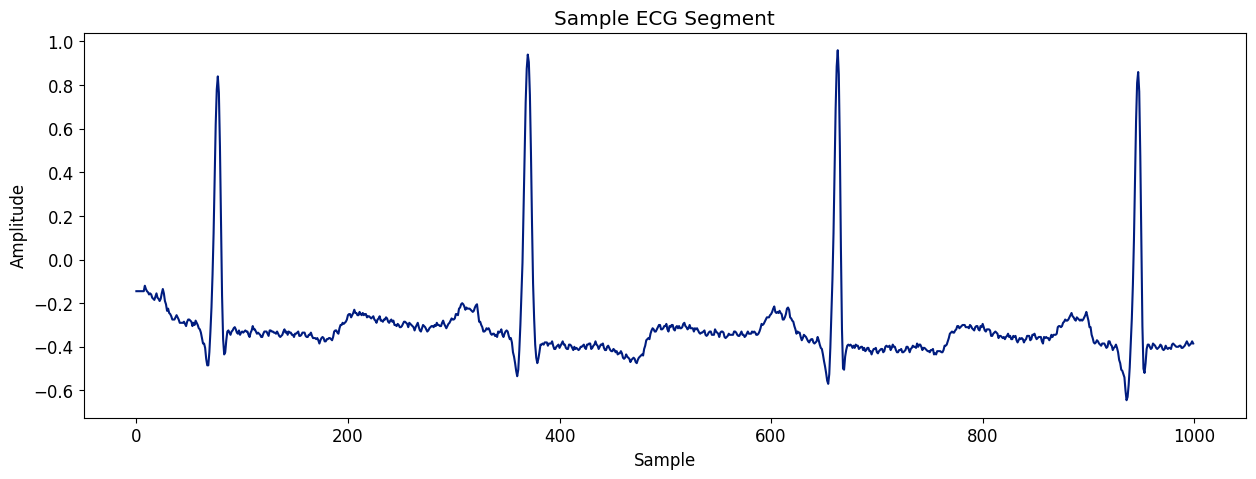

In [12]:
# Load ECG data using the found path
if record_path:
    record = wfdb.rdrecord(record_path)
    signals = record.p_signal

    # Read annotations
    ann = wfdb.rdann(record_path, 'atr')
    annotations = ann.symbol

    # Print data information
    print(f"Signal shape: {signals.shape}")
    print(f"Number of annotations: {len(annotations)}")
    print(f"Unique beat types: {np.unique(annotations)}")

    # Plot sample ECG segment
    plt.figure(figsize=(15, 5))
    plt.plot(signals[:1000, 0])
    plt.title('Sample ECG Segment')
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')
    plt.show()
else:
    print("Please check the dataset extraction and update the path manually.")

Data shape: (2273, 180, 2)
Label distribution: [2239   34]


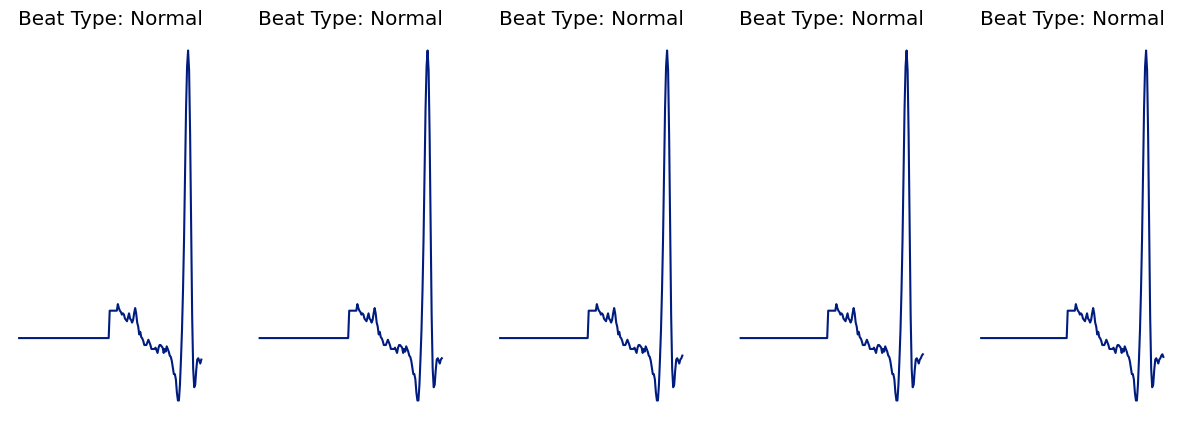

In [14]:
# Preprocess ECG data
window_size = 180

# Normalize signals
signals = (signals - np.mean(signals)) / np.std(signals)

# Extract beats
X = []
y = []

for i, ann in enumerate(annotations):
    if ann in ['N', 'L', 'R', 'A', 'V']:  # Normal and abnormal beats
        # Get window around beat
        start = max(0, i - window_size//2)
        end = min(len(signals), i + window_size//2)
        
        # Pad if necessary
        if start == 0:
            pad_left = window_size//2 - i
            segment = np.pad(signals[start:end], ((pad_left, 0), (0, 0)))
        elif end == len(signals):
            pad_right = window_size//2 - (len(signals) - i)
            segment = np.pad(signals[start:end], ((0, pad_right), (0, 0)))
        else:
            segment = signals[start:end]
        
        X.append(segment)
        
        # Convert annotation to label
        if ann == 'N':
            y.append(0)  # Normal
        else:
            y.append(1)  # Abnormal

X = np.array(X)
y = np.array(y)

print(f"Data shape: {X.shape}")
print(f"Label distribution: {np.bincount(y)}")

# Plot sample beats
plt.figure(figsize=(15, 5))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.plot(X[i, :, 0])
    plt.title(f'Beat Type: {"Normal" if y[i] == 0 else "Abnormal"}')
    plt.axis('off')
plt.show()

# Split data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

## 2. Model Implementation

In [15]:
# Create simple neural network
def create_simple_nn(input_shape):
    """
    create a simple neural network for ecg classification.
    
    requirements:
    - must use at least 2 dense layers
    - must include dropout layers
    - must use binary crossentropy loss
    - must include auc metric
    
    goals:
    - achieve > 75% accuracy on test set
    - achieve auc > 0.80
    - achieve f1-score > 0.70
    - minimize overfitting using dropout
    - train efficiently with appropriate batch size
    
    args:
        input_shape: shape of input data (should be (180, 2) for ecg windows)
    
    returns:
        compiled keras model
    """
    # flatten the input first since we're working with a simple nn
    model = tf.keras.Sequential([
        # flatten input (from window shape to 1d)
        tf.keras.layers.Flatten(input_shape=input_shape),
        
        # first dense layer
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.4),
        
        # second dense layer
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),
        
        # third dense layer (optional but helps with complex patterns)
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.2),
        
        # output layer - single neuron with sigmoid for binary classification
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    # compile with binary crossentropy loss and auc metric
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC()]
    )
    
    return model

# create and compile model
model = create_simple_nn(input_shape=(180, 2))
model.summary()

c:\Users\mihir\OneDrive\Desktop\DataSci223\6-neural-nets-MihirUCSF\venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 360)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        46,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,473 (224.50 KB)

 Trainable params: 57,025 (222.75 KB)

 Non-trainable params: 448 (1.75 KB)

## 3. Training and Evaluation

Class distribution in training set: [1433   21]
Class distribution in validation set: [362   2]
Class distribution in test set: [444  11]
Calculated class weights: {0: np.float64(0.5073272854152129), 1: np.float64(34.61904761904762)}
Epoch 1/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9845 - auc: 0.5887 - loss: 1.9481 - val_accuracy: 0.9945 - val_auc: 0.0898 - val_loss: 0.0533 - learning_rate: 2.0000e-04
Epoch 2/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9859 - auc: 0.8108 - loss: 1.2222 - val_accuracy: 0.9945 - val_auc: 0.1678 - val_loss: 0.0575 - learning_rate: 2.0000e-04
Epoch 3/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9809 - auc: 0.7820 - loss: 1.1521 - val_accuracy: 0.9945 - val_auc: 0.1540 - val_loss: 0.0674 - learning_rate: 2.0000e-04
Epoch 4/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9793 - auc: 0.7899 - loss: 1.0536 - val_accuracy: 0.9945 - val_auc: 0.2169 - val_loss: 0.0780 - learning_rate: 2.0000e-04
Epoch 5/20
46/46 ━━━━━

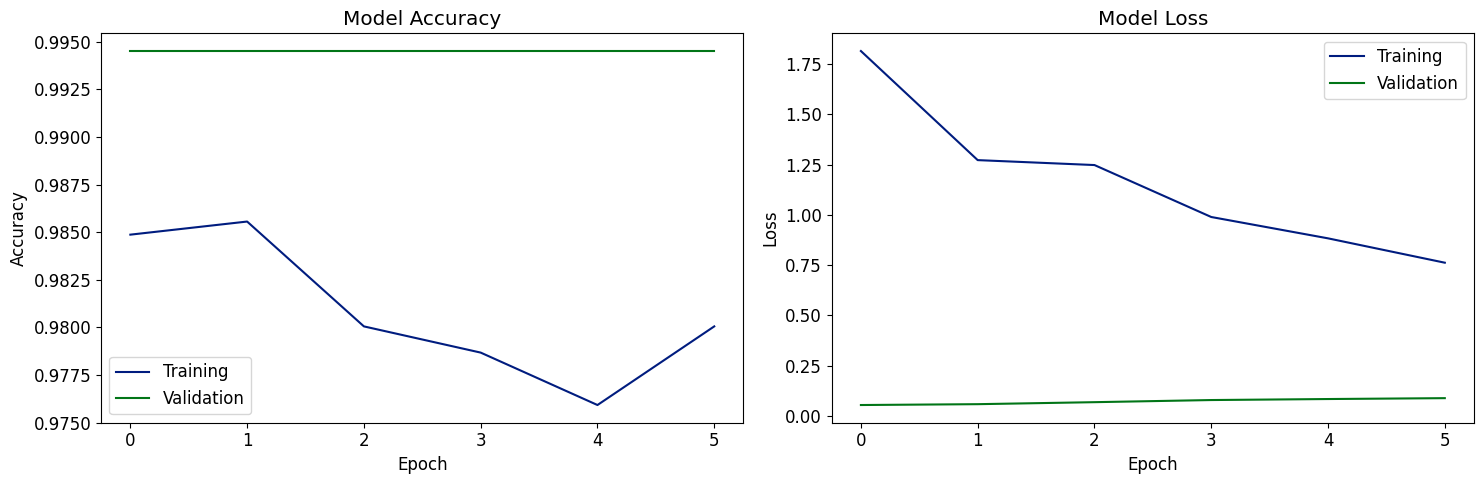

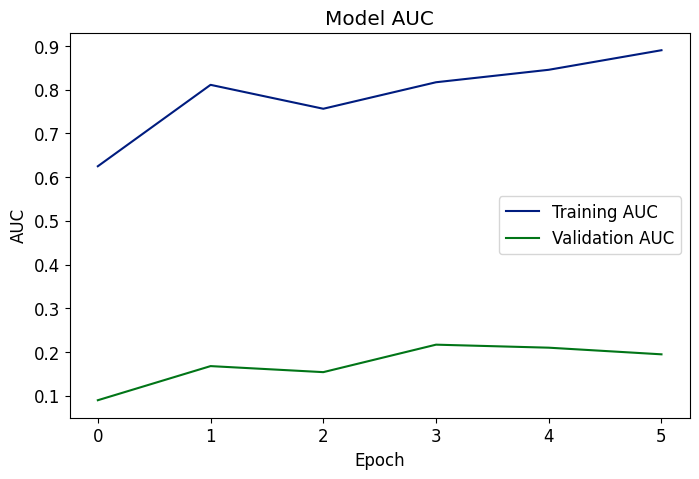

In [19]:
# model training 
# Check class distribution
print(f"Class distribution in training set: {np.bincount(y_train)}")
print(f"Class distribution in validation set: {np.bincount(y_val)}")
print(f"Class distribution in test set: {np.bincount(y_test)}")

# Calculate class weights to account for imbalance
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}
print(f"Calculated class weights: {class_weight_dict}")

# Define callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3
    ),
    tf.keras.callbacks.ModelCheckpoint(
        'models/ecg_classifier.keras',
        save_best_only=True
    )
]

# Train model with class weights
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32,
    callbacks=callbacks,
    class_weight=class_weight_dict  
)

# Plot training curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot accuracy
ax1.plot(history.history['accuracy'], label='Training')
ax1.plot(history.history['val_accuracy'], label='Validation')
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()

# Plot loss
ax2.plot(history.history['loss'], label='Training')
ax2.plot(history.history['val_loss'], label='Validation')
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

plt.tight_layout()
plt.show()

# plot AUC
if 'auc' in history.history:
    plt.figure(figsize=(8, 5))
    plt.plot(history.history['auc'], label='Training AUC')
    plt.plot(history.history['val_auc'], label='Validation AUC')
    plt.title('Model AUC')
    plt.xlabel('Epoch')
    plt.ylabel('AUC')
    plt.legend()
    plt.show()

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9722 - auc: 0.3858 - loss: 0.1627 
Test accuracy: 0.9758
Test AUC: 0.5257
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Optimal threshold (from ROC): 0.0337


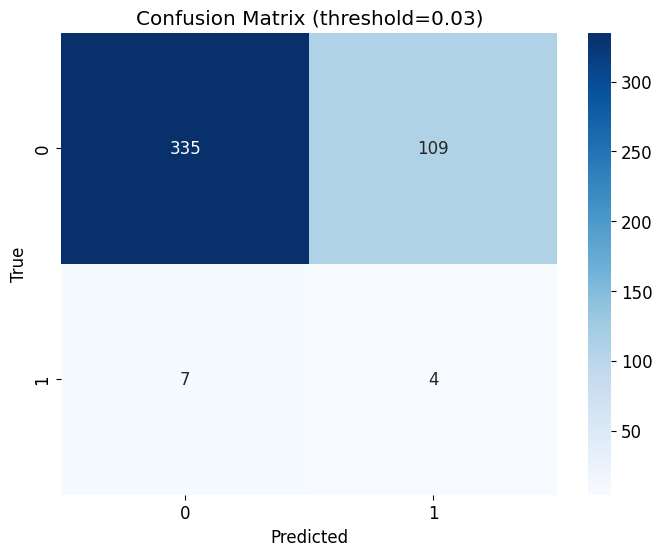

Precision: 0.0354
Recall: 0.3636
F1-score: 0.0645


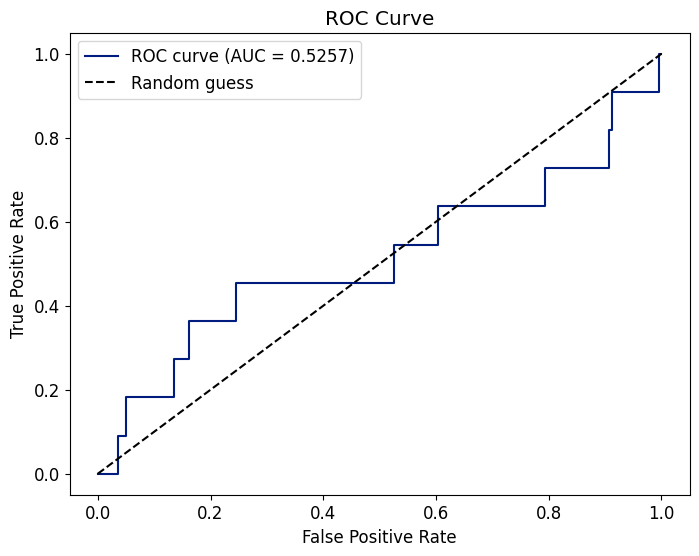

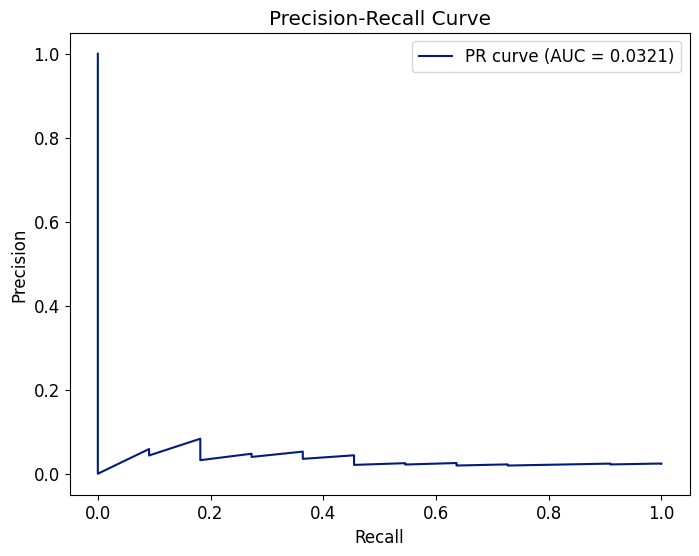

In [20]:
# Evaluate model
test_loss, test_accuracy, test_auc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy:.4f}")
print(f"Test AUC: {test_auc:.4f}")

# Get predictions (probabilities)
predictions_prob = model.predict(X_test).ravel()

# Find optimal threshold using ROC curve
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, auc

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, predictions_prob)
# Calculate optimal threshold (Youden's J statistic)
j_scores = tpr - fpr
optimal_idx = np.argmax(j_scores)
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal threshold (from ROC): {optimal_threshold:.4f}")

# Apply optimal threshold
predicted_labels = (predictions_prob > optimal_threshold).astype(int)

# Calculate confusion matrix
cm = tf.math.confusion_matrix(y_test, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix (threshold={optimal_threshold:.2f})')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Calculate additional metrics
tn, fp, fn, tp = cm.numpy().ravel()
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")  
print(f"F1-score: {f1:.4f}")

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {test_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Plot precision-recall curve
precision_curve, recall_curve, _ = precision_recall_curve(y_test, predictions_prob)
pr_auc = auc(recall_curve, precision_curve)
plt.figure(figsize=(8, 6))
plt.plot(recall_curve, precision_curve, label=f'PR curve (AUC = {pr_auc:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

# Save metrics
metrics = {
    'model': 'ecg_classifier',
    'accuracy': float(test_accuracy),
    'auc': float(test_auc),
    'precision': float(precision),
    'recall': float(recall),
    'f1_score': float(f1),
    'confusion_matrix': cm.numpy().tolist(),
    'optimal_threshold': float(optimal_threshold)
}

# Save to file
with open('results/part_3/ecg_classifier_metrics.txt', 'w') as f:
    f.write(f"model: {metrics['model']}\n")
    f.write(f"accuracy: {metrics['accuracy']}\n")
    f.write(f"auc: {metrics['auc']}\n")
    f.write(f"precision: {metrics['precision']}\n")
    f.write(f"recall: {metrics['recall']}\n")
    f.write(f"f1_score: {metrics['f1_score']}\n")
    f.write(f"optimal_threshold: {metrics['optimal_threshold']}\n")
    f.write(f"confusion_matrix: {metrics['confusion_matrix']}\n")
    f.write("----\n")

#### Interpretation
##### The neural network model was trained to classify ECG heartbeats as normal or abnormal using the MIT-BIH Arrhythmia Database. This type of analysis has significant implications for cardiovascular screening and monitoring. The data initially had severe data imbalance (training data: 1433 normal beats vs. 21 abnormal beats (1.44% abnormal); test data: 444 normal beats vs. 11 abnormal beats (2.42% abnormal)). The AUC value (0.5257) indicates poor discrimanitive ability, the precision is also very low meaning out of the flagged abnormal data the model only correctly flagged 3.54% of abnormal ECGs as abnormal (high false positive rate), the sensitivity of 0.3636 indicates the model detected 36.36% of all actual abnormal beats. The low F1 score also confirms that this model has poor overal performance. 

## Progress Checkpoints

1. **Data Loading**:
   - [ ] Successfully download MIT-BIH dataset
   - [ ] Load and visualize ECG signals
   - [ ] Verify signal shape and annotations

2. **Preprocessing**:
   - [ ] Normalize signals
   - [ ] Extract beat windows
   - [ ] Verify window shapes and labels

3. **Model Implementation**:
   - [ ] Create simple neural network
   - [ ] Verify model architecture
   - [ ] Test model output shape

4. **Training**:
   - [ ] Train model with callbacks
   - [ ] Monitor training progress
   - [ ] Save best model

5. **Evaluation**:
   - [ ] Calculate performance metrics
   - [ ] Save metrics in correct format
   - [ ] Visualize results

## Common Issues and Solutions

1. **Data Loading Issues**:
   - Problem: MIT-BIH dataset not found
   - Solution: Check internet connection and wfdb installation

2. **Preprocessing Issues**:
   - Problem: Signal normalization errors
   - Solution: Check signal statistics and normalization method
   - Problem: Window extraction errors
   - Solution: Verify window size and padding

3. **Model Issues**:
   - Problem: Training instability
   - Solution: Add batch normalization, reduce learning rate
   - Problem: Overfitting
   - Solution: Increase dropout, use data augmentation

4. **Evaluation Issues**:
   - Problem: Metrics format incorrect
   - Solution: Follow the exact format specified
   - Problem: Performance below threshold
   - Solution: Adjust architecture, hyperparameters